In [1]:
import torch
import gym
from torch import nn
import numpy as np
import torch.functional as F
from collections import namedtuple
import random
import math

**making model**

In [2]:
class Network(nn.Module):
  def __init__(self,N):
    super(Network, self).__init__()
    self.layers=nn.ModuleList([
    nn.Linear(4,32),
    nn.Linear(32,64),
    nn.Linear(64,128),
    nn.Linear(128,64),
    nn.Linear(64,2*N)])
    
    self.N=N
  def forward(self,state):
    x=state
    for i in range(4):
      x=self.layers[i](x)
      x=nn.ReLU()(x)
    x=self.layers[4](x)
    return nn.Softmax(dim=2)(x.view(-1, 2,self.N)),nn.LogSoftmax(dim=2)(x.view(-1, 2,self.N))
  

**Replay buffer**

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))
class ReplayMemory:

    def __init__(self, capacity,batch_size):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.batch_size=batch_size

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

**Agent**

Note:In the paper of C51 algorithm,they've chosen Vmin=-10 and Vmax=10.But I examined some values and specualted that -100 and 100 works well for CartPole.

In [4]:
class Agent:
  def __init__(self,N):
    self.q=Network(N)
    self.target=Network(N)
    self.checkpoint=Network(N)
    self.update_target()
    self.Vmin=-100
    self.Vmax=100
    self.gamma=0.99
    self.delta_z=(self.Vmax-self.Vmin)/(N-1)
    self.optimizer =torch.optim.Adam(self.q.parameters(),lr=0.001)

    self.eps=0.2
    self.N=N
    self.t=0

  def action(self,state):
    if np.random.randn()<self.eps:
      return np.random.randint(0,2)
    else:
      # self.q.eval()
        z_dist = torch.from_numpy(
        np.array([[self.Vmin + i * self.delta_z for i in range(self.N)]]))
        z_dist = torch.unsqueeze(z_dist, 2).float()
        Q_dist, _  = self.q(state)#
        Q_dist = Q_dist.detach()
        Q_target = torch.matmul(Q_dist, z_dist)

        return Q_target.argmax(dim=1)[0].detach().cpu().numpy()[0]
  def greedy_action(self,state):
      q,_=self.q(state)
      q=q.detach().cpu().numpy()
      z=np.arange(self.Vmin,self.Vmax+self.delta_z,self.delta_z)
      d=np.sum(z*q,axis=2)
      return d.argmax(axis=1)[0]
  def update_target(self):
    self.target.load_state_dict(self.q.state_dict())

  #for saving the best weight
  def save(self):
    self.checkpoint.load_state_dict(self.q.state_dict())

  #loading the best weight
  def load(self):
    self.q.load_state_dict(self.checkpoint.state_dict())
  
  #update Q network
  def update(self,buffer):
    if len(buffer)<buffer.batch_size:
      return 
    batch=buffer.sample()#taking some sanples
    batch = Transition(*zip(*batch))
    batch_size=buffer.batch_size
    states=batch.state
    next_states=batch.next_state
    rewards=torch.FloatTensor(batch.reward)
    dones=torch.FloatTensor(batch.done)
    actions=batch.action
    actions = torch.tensor(actions).long()
    z_dist = torch.from_numpy(np.array([[self.Vmin + i*self.delta_z for i in range(self.N)]]*batch_size))#making z vector
    z_dist = torch.unsqueeze(z_dist, 2).float()

    _, log_q = self.q(torch.FloatTensor(states))#calculating log pi(Xt,a)
    log_q = log_q[torch.arange(batch_size), actions, :]
    q_next, _ = self.target(torch.FloatTensor(next_states))#calculating pi(Xt+1,a) using Q network
    q_next = q_next.detach()
    Q_target = torch.matmul(q_next, z_dist).squeeze(1)
    
    q_next_t, _ = self.q(torch.FloatTensor(next_states))#calculating pi(Xt+1,a) using target network

    q_target2 = torch.matmul(q_next_t, z_dist).squeeze(1)
    q_next_optimal= q_next[torch.arange(batch_size), torch.argmax(q_target2, dim=1).squeeze(1),:]

    m = torch.zeros(batch_size,self.N)
    for j in range(self.N):
      T_zj = torch.clamp(rewards + self.gamma * (1-dones) * (self.Vmin + j*self.delta_z), min = self.Vmin, max = self.Vmax)
      bj = (T_zj - self.Vmin)/self.delta_z
      l = bj.floor().long()
      u = bj.ceil().long()
      Q_l = torch.zeros(m.size())
      Q_l.scatter_(1, l.reshape((batch_size,1)), q_next_optimal[:,j].unsqueeze(1)*(u.float() -bj.float()).unsqueeze(1))
      Q_u = torch.zeros(m.size())
      Q_u.scatter_(1, u.reshape((batch_size,1)), q_next_optimal[:,j].unsqueeze(1)*(-l.float()+bj.float()).unsqueeze(1))
      m += Q_l
      m += Q_u
    
    self.optimizer.zero_grad()
    loss = - torch.sum(torch.sum(torch.mul(log_q, m),-1),-1) / batch_size
    
    loss.backward()
    self.optimizer.step()
    self.t+=1
  
    #updating target network
    if self.t==10:
  
      self.update_target()
      self.t=0
  
  

  

In [5]:
agent=Agent(51)

In [6]:
EPOCH=200
BATCH_SIZE=64
maxi=0
env=gym.make("CartPole-v0")
rewards=[]
buffer=ReplayMemory(10000,BATCH_SIZE)
for epoch in range(EPOCH):
  state=env.reset()
  t=0
  while True:
    action=agent.action(torch.FloatTensor([state]))
    next_state,reward,done,_=env.step(action)
    buffer.push(state, action, next_state, reward,done)
    agent.update(buffer)
    state=next_state
    t+=reward
    if done:
      break
    
  print("episode:",epoch, "   reward:",t)

  rewards.append(t)
  if t>maxi:
    agent.save()
    maxi=t
    
  

episode: 0    reward: 12.0
episode: 1    reward: 18.0
episode: 2    reward: 31.0
episode: 3    reward: 12.0
episode: 4    reward: 11.0
episode: 5    reward: 10.0
episode: 6    reward: 12.0
episode: 7    reward: 26.0
episode: 8    reward: 12.0
episode: 9    reward: 14.0
episode: 10    reward: 10.0
episode: 11    reward: 11.0
episode: 12    reward: 26.0
episode: 13    reward: 19.0
episode: 14    reward: 14.0
episode: 15    reward: 33.0
episode: 16    reward: 43.0
episode: 17    reward: 22.0
episode: 18    reward: 45.0
episode: 19    reward: 30.0
episode: 20    reward: 54.0
episode: 21    reward: 182.0
episode: 22    reward: 75.0
episode: 23    reward: 70.0
episode: 24    reward: 90.0
episode: 25    reward: 28.0
episode: 26    reward: 62.0
episode: 27    reward: 106.0
episode: 28    reward: 98.0
episode: 29    reward: 28.0
episode: 30    reward: 28.0
episode: 31    reward: 118.0
episode: 32    reward: 146.0
episode: 33    reward: 22.0
episode: 34    reward: 86.0
episode: 35    reward: 31.

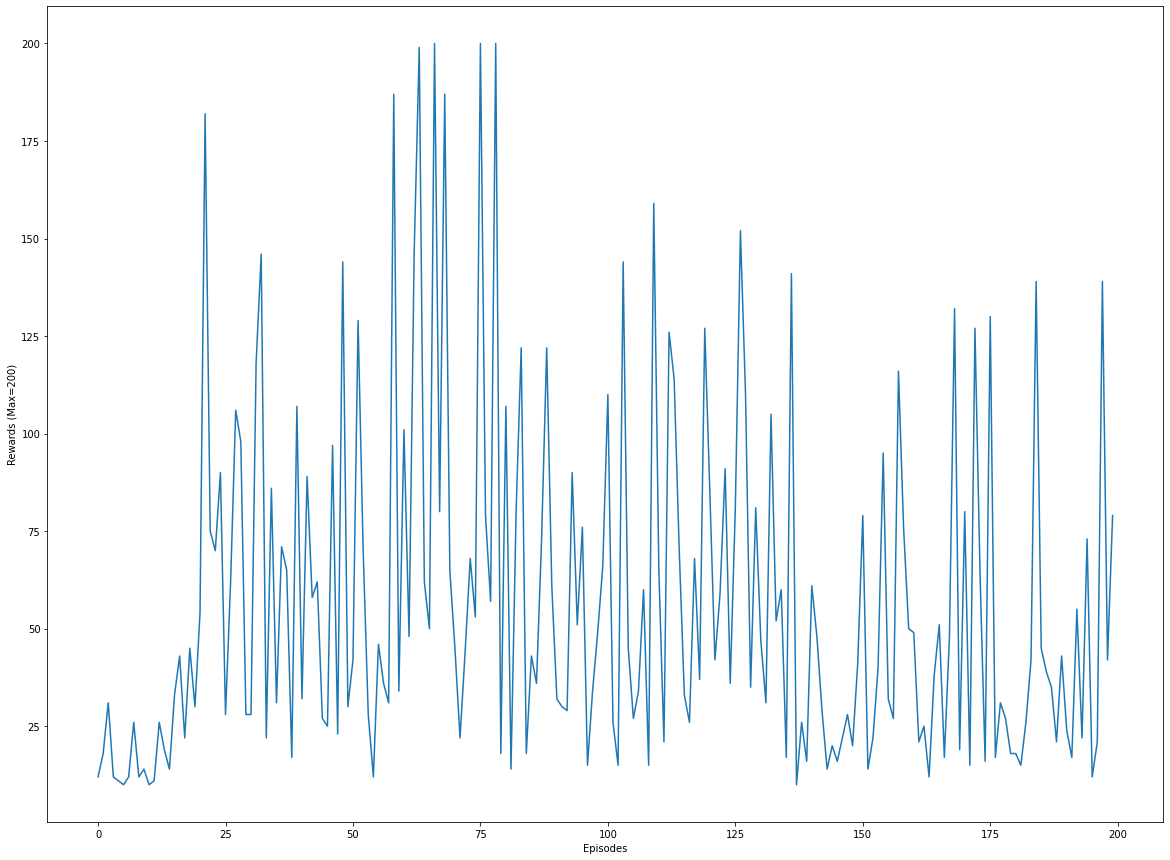

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.plot(np.arange(len(rewards)),rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards (Max=200)")
plt.show()

**Test**

In [17]:
agent.load()
t=0
for i in range(100):
  state=env.reset()


  while True:
    ac=agent.greedy_action(torch.FloatTensor([state]))
    state,reward,done,_=env.step(ac)
    t+=reward
    if done:
      break
print("Average reward:",t/100)
  
  


Average reward: 195.19


Hence,the agent did 100 tests and could achieve average reward of 195.19!

**Run on a signle episode**

In [6]:
#hard copy from: https://github.com/berkeleydeeprlcourse/homework_fall2020/blob/master/hw1/cs285/infrastructure/colab_utils.py (Deep RL course)
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


def show_video():
  mp4list = glob.glob('/content/video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, '/content/video', force=True)
  return env


In [ ]:
!pip install gym pybullet
!sudo apt-get install xvfb
!pip install pyvirtualdisplay

In [12]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
display.start()

In [16]:
agent.load()
t=0
env=wrap_env(gym.make("CartPole-v0"))
state=env.reset()
while True:
  ac=agent.greedy_action(torch.FloatTensor([state]))
  state,reward,done,_=env.step(ac)
  env.render(mode='rgb_array')
  t+=reward
  if done:
    break
print("Reward:",t)
env.close()
show_video()
  
  


Reward: 200.0
